In [1]:
import pandas as pd
import ast
from nltk.tokenize import sent_tokenize
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import logging
from transformers import logging as hf_logging

full_data = pd.read_csv('/kaggle/input/moviesummaries/FinalMovieData.tsv', delimiter='\t')
import dateutil.parser
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def parse_date(date):
    if isinstance(date, str):
        try:
            parsed_date = dateutil.parser.parse(date)
            return pd.Timestamp(parsed_date.year, parsed_date.month, parsed_date.day)
        except Exception as e:
            print(f"Error parsing date '{date}': {e}")
            parts = date.split('-')
            if len(parts) == 2:
                try:
                    return pd.Timestamp(int(parts[0]), int(parts[1]), 1)
                except Exception as e:
                    print(f"Error parsing date '{date}': {e}")
                    return None
            else:
                try:
                    return pd.Timestamp(int(parts[0]), 1, 1)
                except Exception as e:
                    print(f"Error parsing date '{date}': {e}")
                    return None
    else:
        return None
    

# Then apply this function as before and see the printed output.
full_data['Date'] = full_data['Date'].apply(parse_date)

# Drop rows with None in 'Date'
full_data = full_data.dropna(subset=['Date'])

full_data = full_data[full_data['Date'].apply(lambda x: x.year >= 2000)]

# Drop rows with missing 'Country' values
full_data = full_data.dropna(subset=['Country'])

# Convert 'Country' column to dict
full_data['Country'] = full_data['Country'].apply(ast.literal_eval)

# Filter out movies that weren't made in the United States
full_data = full_data[full_data['Country'].apply(lambda x: 'United States of America' in x.values())]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=62362128f4ec2d3c6e0194b7a642bad6a0c093b5b848605482f7f11ff6b0e0f4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Error parsing date '1010-12-02': Out of bounds nanosecond timestamp: 1010-12-02 00:00:00
Error parsing date '1010-12-02': Out of bounds nanosecond timestamp: 1010-01-01 00:00:00


In [2]:
# # Create a mask where each element is True if "Thriller" is in the values of the dictionary, and False otherwise
# mask = full_data['Genres'].apply(lambda d: 'Thriller' in d.values())
# thrillers = full_data[['ID', 'Plot Summary', 'Title']] # add [mask] to filter by Thrillers

summaries = full_data['Plot Summary']

summaries_small = full_data['Plot Summary'].reset_index(drop=True)
titles_small = full_data['Title'].reset_index(drop=True)
ids_small = full_data['ID'].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(summaries_small.shape)

(6700,)


In [3]:
# BERT Implementation

# SBERT model 'all-mpnet-base-v2'
# https://www.sbert.net/docs/pretrained_models.html#model-overview
model = SentenceTransformer('all-mpnet-base-v2')

# Disable logging from the transformers library
hf_logging.set_verbosity_error()

# Disable logging from the sentence_transformers library
logger = logging.getLogger("sentence_transformers")
logger.setLevel(logging.ERROR)

def sbert_tokenize_and_embed_data(raw_data):
    data = []
    for summary in raw_data:
        sent_embeds = model.encode(sent_tokenize(summary))
        avg_embed = np.mean(sent_embeds, axis=0)
        data.append(avg_embed)
    return data

# tokenize and embed data with SBERT
processed_data = sbert_tokenize_and_embed_data(summaries_small)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
from sklearn.cluster import SpectralClustering

number_of_clusters = 1300

# Perform clustering with Spectral
clustering = SpectralClustering(n_clusters=number_of_clusters, assign_labels='discretize',random_state=7).fit(processed_data)

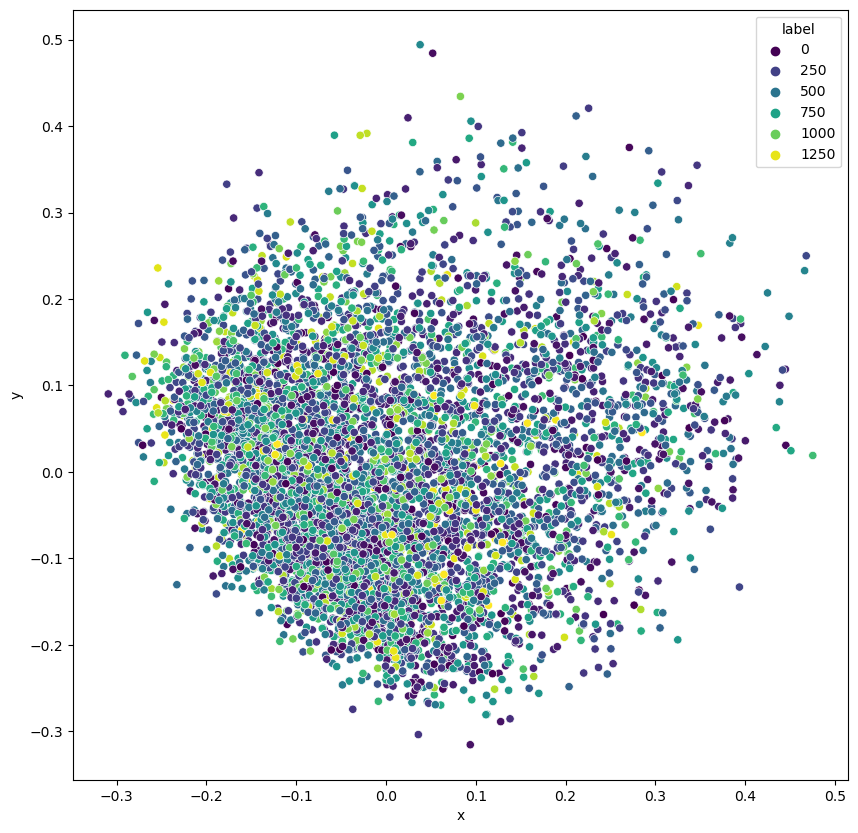

Cluster 0 summaries:
            ID                   Title                                            Summary
255     146947              Spider-Man  High-school senior Peter Parker  lives in Fore...
891   11610890    Earth vs. the Spider  A shy, obsessive comic book fan injects himsel...
1161    612052            Spider-Man 2  {{plot}}  Peter Parker struggles to balance hi...
1679  33942920               Neverland  In 1906 London, orphan Peter Pan  is one of a ...
2187  28224334             Dream House  Will Atenten , his wife, Libby , and two daugh...
2670    702117            Spider-Man 3  Peter Parker plans to propose to Mary Jane Wat...
2886   2319006              Spiderbabe  Patricia Porker  is a shy New Jersey high scho...
3484   9013167        The Golden Blaze  {{Expand section}} The bond between son Jason ...
5221  25862453  The Amazing Spider-Man   As a child, Peter Parker discovers his father...
5818    302491            The Majestic  {{plot}} Peter Appleton , an up-and-com

In [5]:
# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles_small
df['Summary'] = summaries_small
df['ID'] = ids_small

# print(df)

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(75):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [6]:
cluster_counts = df['label'].value_counts()
largest_cluster = cluster_counts.idxmax()
largest_cluster_size = cluster_counts.max()

print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")

The largest cluster is: 289 with size: 28
